# [`Nibabel`](http://nipy.org/nibabel): Reading and writing neuroimaging file-formats


### Why Nibabel? 
- Pure Python (no need to compile extensions).
- Handles many file formats.
- Very well-tested. 
- Active developer community. 


The following is based on a [tutorial](http://nipy.org/nibabel/coordinate_systems.html) that is part of the nibabel documentation.

### A nibabel (and nipy) image is the association of three things:

- The image data array: a 3D or 4D array of image data
- An affine array that tells you the position of the image array data in a reference space.
- image metadata (data about the data) describing the image, usually in the form of an image header.

In the following, we will look at how the affine array describes the position of the image data in a reference space. 

On the way we will define what we mean by reference space, and the reference spaces that Nibabel uses.

In [1]:
import numpy as np
import nibabel as nib

In [2]:
epi_img = nib.load('data/someones_epi.nii.gz')
epi_data = epi_img.get_data()
print(epi_data.shape)

(53, 61, 33)


In [3]:
epi_affine = epi_img.get_affine()
print(epi_affine)

[[  3.           0.           0.         -78.        ]
 [  0.           2.86600947  -0.88656062 -76.        ]
 [  0.           0.88656062   2.86600947 -64.        ]
 [  0.           0.           0.           1.        ]]


In [4]:
epi_hdr = epi_img.get_header()
print(epi_hdr)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : 
db_name         : 
extents         : 0
session_error   : 0
regular         : 
dim_info        : 0
dim             : [ 3 53 61 33  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.  3.  3.  3.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : 
aux_file        : 
qform_code      : mni
sform_code      : mni
quatern_b       : 0.149438127875
quatern_c       : -0.0
quatern_d       : -0.0
qoffset_x       : -78.0
qoffset_y       : -76.0
qoffset_z       : -64.0
srow_x          : [  3.   0.   0. -78.]
srow_y          : [  0

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

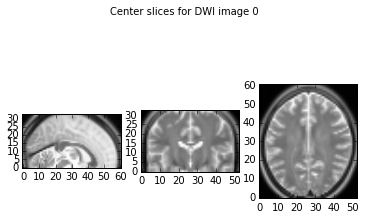

In [6]:
slice_0 = epi_data[epi_data.shape[0]//2, :, :]  # What does '//' denote? 
slice_1 = epi_data[:, epi_data.shape[1]//2, :]
slice_2 = epi_data[:, :, epi_data.shape[2]//2]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for DWI image 0")  

## We also collected an anatomical image for the same subject

In [7]:
anat_img = nib.load('data/someones_anatomy.nii.gz')
anat_data = anat_img.get_data()
print(anat_data.shape)

(57, 67, 56)


In [8]:
anat_affine = anat_img.get_affine()
print(anat_affine)

[[  2.75   0.     0.   -78.  ]
 [  0.     2.75   0.   -91.  ]
 [  0.     0.     2.75 -91.  ]
 [  0.     0.     0.     1.  ]]


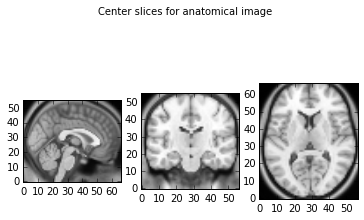

In [9]:
show_slices([anat_data[anat_data.shape[0]//2, :, :], 
             anat_data[:, anat_data.shape[1]//2, :],
             anat_data[:, :, anat_data.shape[2]//2]])

plt.suptitle("Center slices for anatomical image")  

## Coordinate systems and affine transformations 


### Voxel coordinates are coordinates in the image data array

In the code above, slice_0 from the DWI data is a 2D slice from a 3D image (selected from the full 4D time-series). 
The plot of the DWI slices displays the slices in grayscale (graded between black for the minimum value, white for the maximum). Each pixel in the slice grayscale image represents a voxel, because this 2D image represents a slice from the 3D image with a certain thickness (based on what you've seen so far - *how thick is it?*)

The 3D array is therefore also a voxel array. As for any array, we can select particular values by indexing. For example, we can get the value for the middle voxel in the first volume of the DWI data array like this:

In [10]:
n_i, n_j, n_k = epi_data.shape
center_i = (n_i - 1) // 2.
center_j = (n_j - 1) // 2.
center_k = (n_k - 1) // 2.
print(center_i, center_j, center_k)

(26.0, 30.0, 16.0)


In [11]:
center_vox_value = epi_data[center_i, center_j, center_k]
print(center_vox_value)

81.549287796


/Users/arokem/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


The values `(26, 30, 16)` are indices into the data array epi_img_data. 
`(26, 30, 16)` is therefore a ‘voxel coordinate’ - a coordinate into the voxel array.

A coordinate is a set of numbers giving positions relative to a set of axes. In this case 26 is a position on the first array axis, where the axis is of length `epi_data.shape[0]`, and therefore goes from 0 to 52 (`epi_data.shape == (53, 61, 33)`). Similarly `30` gives a position on the second axis (0 to 60) and `16` is the position on the third axis (0 to 32).

### Voxel coordinates and points in space
The voxel coordinate tells us almost nothing about where the data came from in terms of position in the scanner. 
For example, let’s say we have the voxel coordinate `(26, 30, 16)`. Without more information we have no idea whether this voxel position is on the left or right of the brain, or came from the left or right of the scanner.

This is because the scanner allows us to collect voxel data in almost any arbitrary position and orientation within the magnet.

In the case of Someone’s EPI, we took transverse slices at a moderate angle to the floor to ceiling direction. This localizer image from the scanner console has a red box that shows the position of the slice block for someones_epi.nii.gz and a blue box for the slice block of someones_anatomy.nii.gz:



<img src="./images/localizer.png">

The localizer is oriented to the magnet, so that the left and right borders of the image are parallel to the floor of the scanner room, with the left border being towards the floor and the right border towards the ceiling.

You will see from the labels on the localizer that the center of the EPI voxel data block (at 26, 30, 16 in epi_img_data) is not quite at the center of magnet bore (the magnet isocenter).

We have an anatomical and an EPI scan, and later on we will surely want to be able to relate the data from someones_epi.nii.gz to someones_anatomy.nii.gz. We can’t easily do this at the moment, because we collected the anatomical image with a different field of view and orientation to the EPI image, so the voxel coordinates in the EPI image refer to different locations in the magnet to the voxel coordinates in the anatomical image.

We solve this problem by keeping track of the relationship of voxel coordinates to some reference space. In particular, the affine array stores the relationship between voxel coordinates in the image data array and coordinates in the reference space. We store the relationship of voxel coordinates from `someones_epi.nii.gz` and the reference space, and also the (different) relationship of voxel coordinates in `someones_anatomy.nii.gz` to the same reference space. Because we know the relationship of (voxel coordinates to the reference space) for both images, we can use this information to relate voxel coordinates in `someones_epi.nii.gz` to spatially equivalent voxel coordinates in `someones_anatomy.nii.gz`.

### The scanner-subject reference space

What does “space” mean in the phrase “reference space”? The space is defined by an ordered set of axes. For our 3D spatial world, it is a set of 3 independent axes.

We can decide what space we want to use, by choosing these axes. We need to choose the origin of the axes, their direction and their units.

To start with, we define a set of three orthogonal scanner axes.



### The scanner axes

The origin of the axes is at the magnet isocenter. This is coordinate `(0, 0, 0)` in our reference space. 

All three axes pass through the isocenter.

The units for all three axes are millimeters.

Imagine an observer standing behind the scanner looking through the magnet bore towards the end of the scanner bed. Imagine a line traveling towards the observer through the center of the magnet bore, parallel to the bed, with the zero point at the magnet isocenter, and positive values closer to the observer. Call this line the scanner-bore axis.

Draw a line traveling from the scanner room floor up through the magnet isocenter towards the ceiling, at right angles to the scanner bore axis. 0 is at isocenter and positive values are towards the ceiling. Call this the scanner-floor/ceiling axis.

Draw a line at right angles to the other two lines, traveling from the observer’s left, parallel to the floor, and through the magnet isocenter to the observer’s right. 0 is at isocenter and positive values are to the right. Call this the scanner-left/right.

If we make the axes have order (scanner left-right; scanner floor-ceiling; scanner bore) then we have an ordered set of 3 axes and therefore the definition of a 3D space. Call the first axis the “X” axis, the second “Y” and the third “Z”. A coordinate of `(x, y, z)=(10,−5,−3)` in this space refers to the point in space 10mm to the (fictional observer’s) right of isocenter, 5mm towards the floor from the isocenter, and 3mm towards the foot of the scanner bed. This reference space is sometimes known as “scanner XYZ”. 


### From scanner to subject

If the subject is lying in the usual position for a brain scan, face up and head first in the scanner, then scanner-left/right is also the left-right axis of the subject’s head, scanner-floor/ceiling is the anterior-posterior axis of the head and scanner-bore is the inferior-posterior axis of the head.

Sometimes the subject is not lying in the standard position. For example, the subject may be lying with their face pointing to the right (in terms of the scanner-left/right axis). In that case “scanner XYZ” will not tell us about the subject’s left and right, but only the scanner left and right. We might prefer to know where we are in terms of the subject’s left and right.

To deal with this problem, most reference spaces use subject- or patient- centered scanner coordinate systems. In these systems, the axes are still the scanner axes above, but the ordering and direction of the axes comes from the position of the subject. The most common subject-centered scanner coordinate system in neuroimaging is called “scanner RAS” (right, anterior, superior). Here the scanner axes are reordered and flipped so that the first axis is the scanner axis that is closest to the left to right axis of the subject, the second is the closest scanner axis to the anterior-posterior axis of the subject, and the third is the closest scanner axis to the inferior-superior axis of the subject. For example, if the subject was lying face to the right in the scanner, then the first (X) axis of the reference system would be scanner-floor/ceiling, but reversed so that positive values are towards the floor. This axis goes from left to right in the subject, with positive values to the right. The second (Y) axis would be scanner-left/right (anterior-posterior in the subject), and the Z axis would be scanner-bore (inferior-posterior).



### Naming reference spaces

Reading names of reference spaces can be confusing because of different meanings that authors use for the same terms, such as ‘left’ and ‘right’.

We are using the term “RAS” to mean that the axes are (in terms of the subject): left to Right; posterior to Anterior; and inferior to Superior, respectively. Although it is common to call this convention “RAS”, it is not quite universal, because some use “R”, “A” and “S” in “RAS” to mean that the axes starts on the right, anterior, superior of the subject, rather than ending on the right, anterior, superior. In other words, they would use “RAS” to refer to a coordinate system we would call “LPI”. To be safe, we’ll call our interpretation of the RAS convention “RAS+”, meaning that Right, Anterior, Posterior are all positive values on these axes.

Some people also use “right” to mean the right hand side when an observer looks at the front of the scanner, from the foot the scanner bed. Unfortunately, this means that you have to read coordinate system definitions carefully if you are not familiar with a particular convention. We `nibabel` / `nipy` folks agree with most of our brain imaging friends and many of our enemies in that we always use “right” to mean the subject’s right.

### Voxel coordinates are in voxel space

We have not yet made this explicit, but voxel coordinates are also in a space. In this case the space is defined by the three voxel axes (first axis, second axis, third axis), where `0, 0, 0` is the center of the first voxel in the array and the units on the axes are voxels. Voxel coordinates are therefore defined in a reference space called voxel space.

We have voxel coordinates (in voxel space).  We want to get scanner RAS+
coordinates corresponding to the voxel coordinates.  We need a *coordinate
transform* to take us from voxel coordinates to scanner RAS+ coordinates.

In general, we have some voxel space coordinate $(i, j, k)$, and we want to
generate the reference space coordinate $(x, y, z)$.

Imagine we had solved this, and we had a coordinate transform function $f$
that accepts a voxel coordinate and returns a coordinate in the reference
space:

$(x, y, z) = f(i, j, k)$

$f$ accepts a coordinate in the *input* space and returns a coordinate in the
*output* space.  In our case the input space is voxel space and the output
space is scanner RAS+.

In theory $f$ could be a complicated non-linear function, but in practice, we
know that the scanner collects data on a regular grid.  This means that the
relationship between $(i, j, k)$ and $(x, y, z)$ is linear (actually
*affine*), and can be encoded with linear (actually affine) transformations
comprising translations, rotations and zooms ([wikipedia linear transform](https://en.wikipedia.org/wiki/Linear_map),
[wikipedia affine transform](https://en.wikipedia.org/wiki/Affine_transformation)).

### An aside: matrix multiplication

One of the best ways to represent a linear (affine) transformation, is a matrix. 

Some 3-by-3 matrices encode functions of the kind we are looking for: 

If $\begin{bmatrix} i\\ j\\ k\\ \end{bmatrix}$ is a voxel coordinate.

Then a *matrix multiplication*: 

$A \begin{bmatrix} i\\ j\\ k\\ \end{bmatrix} = f(i, j, k) = (x, y, z)$ 

where $A$ is a 3x3 matrix:

$A= 
\begin{bmatrix}
A_{11} & A_{12} & A_{13} \\
A_{21} & A_{22} & A_{23} \\
A_{31} & A_{32} & A_{33} \\
\end{bmatrix}$

and the multiplication is defined as: 

$A \begin{bmatrix} i\\ j\\ k\\ \end{bmatrix} = \begin{bmatrix} A_{11} i + A_{12} j + A_{13} k \\ A_{21} i + A_{22} j + A_{23} k \\ A_{11} i + A_{12} j + A_{13} k \end{bmatrix}$


More generally multiplication between two 3x3 matrices: 

$A B = \begin{bmatrix} A_{11} B_{11} + A_{12} B_{21} + A_{13} B_{31} & A_{11} B_{12} + A_{12} B_{22} + A_{13} B_{23} & A_{11} B_{13} + A_{12} B_{32} + A_{13} B_{33} \\ A_{21} B_{11} + A_{22} B_{21} + A_{23} B_{31} & A_{21} B_{12} + A_{22} B_{22} + A_{23} B_{23} & A_{21} B_{13} + A_{22} B_{32} + A_{23} B_{33} \\ A_{31} B_{11} + A_{32} B_{21} + A_{33} B_{31} & A_{31} B_{12} + A_{32} B_{22} + A_{33} B_{23} & A_{31} B_{13} + A_{32} B_{32} + A_{33} B_{33}                    
\end{bmatrix}$


Scaling (zooming) in three dimensions can be represented by a diagonal 3 by 3
matrix.  Here's how to zoom the first dimension by $p$, the second by $q$ and
the third by $r$ units:

$\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} =
\begin{bmatrix}
p i\\
q j\\
r k\\
\end{bmatrix} =
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}$

A rotation in three dimensions can be represented as a 3 by 3 *rotation
matrix* ([wikipedia rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix)).  
For example, here is a rotation by $\theta$ radians around the third array axis:

$
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} =
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$

This is a rotation by $\phi$ radians around the second array axis:

$
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} =
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$

A rotation of $\gamma$ radians around the first array axis:

$
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} =
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\gamma) & 0 & -\sin(\gamma) \\
0 & \sin(\gamma) & 0 & \cos(\gamma) \\
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$

Zoom and rotation matrices can be combined by matrix multiplication.

Here's a scaling of $p, q, r$ units followed by a rotation of $\theta$ radians
around the third axis followed by a rotation of $\phi$ radians around the
second axis:


$
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} =
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$ 

This can also be written:

$
M =
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} = M
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$

This might be obvious because the matrix multiplication is the result of
applying each transformation in turn on the coordinates output from the
previous transformation. Combining the transformations into a single matrix
$M$ works because matrix multiplication is associative: $ABCD = (ABC)D$.

A translation in three dimensions can be represented as a length 3 vector to
be added to the length 3 coordinate.  For example, a translation of $a$ units
on the first axis, $b$ on the second and $c$ on the third might be written
as:

$
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} =
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix} +
\begin{bmatrix}
a \\
b \\
c \\
\end{bmatrix}
$ 

We can write our function $f$ as a combination of matrix multiplication by
some 3 by 3 rotation / zoom matrix $M$ followed by addition of a 3 by 1
translation vector $(a, b, c)$

$
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} = M
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix} +
\begin{bmatrix}
a\\
b\\
c\\
\end{bmatrix}
$ 

We could record the parameters necessary for $f$ as the 3 by 3 matrix, $M$
and the 3 by 1 vector $(a, b, c)$.

In fact, the 4 by 4 image *affine array* does include exactly this
information. If $m_{ij}$ is the value in row $i$ column $j$ of matrix $M$,
then the image affine matrix $A$ is:

$
A =
\begin{bmatrix}
m_{11} & m_{12} & m_{13} & a \\
m_{21} & m_{22} & m_{23} & b \\
m_{31} & m_{32} & m_{33} & c \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$ 

Why the extra row of $[0, 0, 0, 1]$?  We need this row because we have
rephrased the combination of rotations / zooms and translations as a
transformation in *homogenous coordinates* (see `wikipedia homogenous
coordinates`_).  This is a trick that allows us to put the translation part
into the same matrix as the rotations / zooms, so that both translations and
rotations / zooms can be applied by matrix multiplication.  In order to make
this work, we have to add an extra 1 to our input and output coordinate
vectors:

$
\begin{bmatrix}
x\\
y\\
z\\
1\\
\end{bmatrix} =
\begin{bmatrix}
m_{11} & m_{12} & m_{13} & a \\
m_{21} & m_{22} & m_{23} & b \\
m_{31} & m_{32} & m_{33} & c \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\begin{bmatrix}
i\\
j\\
k\\
1\\
\end{bmatrix}
$

This results in the same transformation as applying $M$ and $(a, b, c)$
separately. One advantage of encoding transformations this way is that we can
combine two sets of [rotations, zooms, translations] by matrix multiplication
of the two corresponding affine matrices.

In practice, although it is common to combine 3D transformations using 4 by 4
affine matrices, we usually *apply* the transformations by breaking up the
affine matrix into its component $M$ matrix and $(a, b, c)$ vector and doing:

$
\begin{bmatrix}
x\\
y\\
z\\
\end{bmatrix} = M
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix} +
\begin{bmatrix}
a\\
b\\
c\\
\end{bmatrix}
$

As long as the last row of the 4 by 4 is $[0, 0, 0, 1]$, applying the
transformations in this way is mathematically the same as using the full 4 by
4 form, without the inconvenience of adding the extra 1 to our input and
output vectors.


### The inverse of the affine gives the mapping from scanner to voxel

The affine arrays we have described so far have another pleasant property - they are usually invertible.  

#### Inverse of a matrix
The inverse of a matrix $A$ is the matrix $A^{-1}$ such that $I = A^{-1} A$, where $I$ is the identity
matrix.  Put another way:

$
\begin{bmatrix}
x\\
y\\
z\\
1\\
\end{bmatrix} = A
\begin{bmatrix}
i\\
j\\
k\\
1\\
\end{bmatrix}
$ 

$
\begin{bmatrix}
i\\
j\\
k\\
1\\
\end{bmatrix}
= A^{-1}
\begin{bmatrix}
x\\
y\\
z\\
1\\
\end{bmatrix}
$

That means that the inverse of the affine matrix gives the transformation from
scanner RAS+ coordinates to voxel coordinates in the image data.

Now imagine we have affine array $A$ for ``someones_epi.nii.gz``, and affine array
$B$ for ``someones_anatomy.nii.gz``.  $A$ gives the mapping from voxels in the
image data array of ``someones_epi.nii.gz`` to millimeters in scanner RAS+.  $B$
gives the mapping from voxels in image data array of
``someones_anatomy.nii.gz`` to *the same* scanner RAS+.  Now let's say we have
a particular voxel coordinate $(i, j, k)$ in the data array of
``someones_epi.nii.gz``, and we want to find the voxel in
``someones_anatomy.nii.gz`` that is in the same spatial position.  Call this
matching voxel coordinate $(i', j', k')$ . We first apply the transform from
``someones_epi.nii.gz`` voxels to scanner RAS+ ($A$) and then apply the transform
from scanner RAS+ to voxels in ``someones_anatomy.nii.gz`` ($B^{-1}$):

$
\begin{bmatrix}
i'\\
j'\\
k'\\
1\\
\end{bmatrix} = B^{-1} A
\begin{bmatrix}
i\\
j\\
k\\
1\\
\end{bmatrix}
$

### The affine by example

Now you should understand what each part of the affine for the EPI scan means (For example, why is the last row $[0, 0, 0, 1]$? What does it mean that the last column is negative? What happens to the origin ($(0,0,0)$) when it is transformed through this?):

In [12]:
epi_affine

array([[  3.        ,   0.        ,   0.        , -78.        ],
       [  0.        ,   2.86600947,  -0.88656062, -76.        ],
       [  0.        ,   0.88656062,   2.86600947, -64.        ],
       [  0.        ,   0.        ,   0.        ,   1.        ]])

### Applying the affine

To make the affine simpler to apply, we split it into $M$ and $(a, b, c)$:

In [13]:
M = epi_img.affine[:3, :3]
abc = epi_img.affine[:3, 3]

Then we can define our function $f$:

In [14]:
def f(i, j, k):
    """ Transform from voxel to scanner coordinates
    
    Parameters
    ----------
    i, j, k : int 
        voxel coordinates 
    
    Returns
    -------
    x, y, z : float array 
        scanner coordinates
    
    """
    return np.dot(M, [i, j, k]) + abc

In [15]:
epi_vox_center = (np.array(epi_data.shape) - 1) / 2.

In [16]:
f(epi_vox_center[0], epi_vox_center[1], epi_vox_center[2])

array([ 0.        , -4.20468569,  8.45297015])

Or more generally:

In [17]:
def f(i, j, k, affine):
    """ 
    Transform from voxel to scanner coordinates
    
    Parameters
    ----------
    i, j, k : voxel coordinates 
    
    affine : 4x4 array
       The affine transformation of the image
    
    Returns
    -------
    x, y, z : scanner coordinates
    
    """
    M = affine[:3, :3]
    abc = affine[:3, 3]
    return np.dot(M, [i, j, k]) + abc

In [18]:
f(epi_vox_center[0], epi_vox_center[1], epi_vox_center[2], epi_affine)

array([ 0.        , -4.20468569,  8.45297015])

### What does it mean?

That means the center of the image field of view is at the isocenter of the
magnet on the left to right axis, and is around 4.2mm posterior to the
isocenter and ~8.5 mm above the isocenter.

The parameters in the affine array can therefore give the position of any
voxel coordinate, relative to the scanner RAS+ reference space.

We get the same result from applying the affine directly instead of using $M$
and $(a, b, c)$ in our function. As above, we need to add a 1
to the end of the vector to apply the 4 by 4 affine matrix.

In [19]:
np.dot(epi_affine, np.concatenate([epi_vox_center, [1]]))

array([ 0.        , -4.20468569,  8.45297015,  1.        ])

In fact nibabel has a function `apply_affine` that applies an affine to an
$(i, j, k)$ point by splitting the affine into $M$ and $abc$ then multiplying
and adding as above:

In [20]:
from nibabel.affines import apply_affine
apply_affine(epi_img.affine, epi_vox_center)

array([ 0.        , -4.20468569,  8.45297015])

Now we can apply the affine, we can use matrix inversion on the anatomical
affine to map between voxels in the EPI image and voxels in the anatomical
image.

In [21]:
import numpy.linalg as npl
epi_vox2anat_vox = np.dot(npl.inv(anat_affine), epi_img.affine)

What is the voxel coordinate in the anatomical corresponding to the voxel
center of the EPI image?

In [22]:
print(apply_affine(epi_vox2anat_vox, epi_vox_center))

[ 28.36363636  31.56193248  36.16471642]


The voxel coordinate of the center voxel of the anatomical image is:

In [23]:
anat_vox_center = np.array(anat_data.shape) // 2.
print(anat_vox_center)

[ 28.  33.  28.]


The voxel location in the anatomical image that matches the center voxel of
the EPI image is nearly exactly half way across the first axis, a voxel or two
back from the anatomical voxel center on the second axis, and about 9 voxels
above the anatomical voxel center.  We can check the localizer image 
by eye to see whether this makes sense, by seeing how the
red EPI field of view center relates to the blue anatomical field of view
center and the blue anatomical image field of view.

### The affine as a series of transformations

You can also think of the image affine as a combination of a series of
transformations to go from voxel coordinates to mm coordinates in terms of the
magnet isocenter.  Here is the EPI affine broken down into a series of
transformations, with the results shown on the localizer image:

<img src="./images/illustrating_affine.png">

We start by putting the voxel grid onto the isocenter coordinate
system, so a translation of one voxel equates to a translation of one
millimeter in the isocenter coordinate system.  Our EPI image would then have
the black bounding box in the image above.  Next we scale the voxels to
millimeters by scaling by the voxel size (green bounding box). We could do
this with an affine:

In [24]:
scaling_affine = np.array([[3, 0, 0, 0],
                           [0, 3, 0, 0],
                           [0, 0, 3, 0],
                           [0, 0, 0, 1]])

After applying this affine, when we move one voxel in any direction, we are
moving 3 millimeters in that direction:

In [25]:
one_vox_axis_0 = [1, 0, 0]
print(apply_affine(scaling_affine, one_vox_axis_0))

[3 0 0]


Next we rotate the scaled voxels around the first axis by 0.3 radians (see above for rotation matrices):

In [26]:
cos_gamma = np.cos(0.3)
sin_gamma = np.sin(0.3)
rotation_affine = np.array([[1, 0, 0, 0],
                            [0, cos_gamma, -sin_gamma, 0],
                            [0, sin_gamma, cos_gamma, 0],
                            [0, 0, 0, 1]])
affine_so_far = np.dot(rotation_affine, scaling_affine)
print(affine_so_far)

[[ 3.          0.          0.          0.        ]
 [ 0.          2.86600947 -0.88656062  0.        ]
 [ 0.          0.88656062  2.86600947  0.        ]
 [ 0.          0.          0.          1.        ]]


The EPI voxel block coordinates transformed by `affine_so_far` are at the
position of the yellow box on the figure.

Finally we translate the 0, 0, 0 coordinate at the bottom, posterior, left
corner of our array to be at its final position relative to the isocenter,
which is -78, -76, -64:

In [27]:
translation_affine = np.array([[1, 0, 0, -78],
                               [0, 1, 0, -76],
                               [0, 0, 1, -64],
                               [0, 0, 0, 1]])
whole_affine = np.dot(translation_affine, affine_so_far)
print(whole_affine)

[[  3.           0.           0.         -78.        ]
 [  0.           2.86600947  -0.88656062 -76.        ]
 [  0.           0.88656062   2.86600947 -64.        ]
 [  0.           0.           0.           1.        ]]


This brings the affine-transformed voxel coordinates to the red box on the
figure, matching the position on the localizer image.

#### Does it matter in what order we apply these transformations? Why is that the answer?

### To resample from one space to the other, we will use `dipy`'s alignment module 

We'll write a little function that uses the `AffineMap` object: 

In [28]:
from dipy.align.imaffine import AffineMap
def resample_volume(moving, static):
    """ 
    Resample a nifti image into the space of another nifti image
    
    Parameters
    ----------
    moving : Nifti1Image
        The 'source' image.
    static : Nifti1Image
        The 'target' image.
        
    Returns
    -------
    resampled_img : Nifti1Image
       The source data in the target space, with the target affine
    """
    affine_map = AffineMap(np.eye(4),
                           static.shape, static.affine, 
                           moving.shape, moving.affine)
    
    resampled = affine_map.transform(moving.get_data())
    return nib.Nifti1Image(resampled, static.get_affine())

In [29]:
resampled_epi = resample_volume(epi_img, anat_img)
resampled_epi_data = resampled_epi.get_data()

In [30]:
print(epi_data.shape)
print(resampled_epi_data.shape)

(53, 61, 33)
(57, 67, 56)


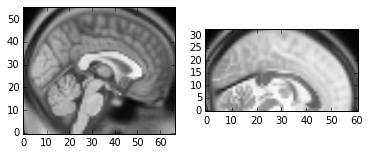

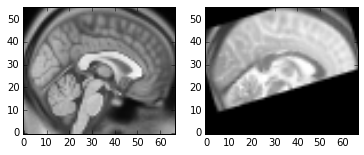

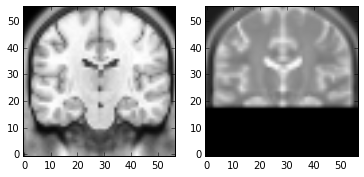

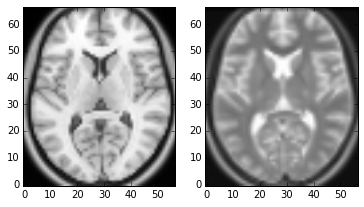

In [31]:
show_slices([anat_data[anat_data.shape[0]//2, :, :], 
             epi_data[epi_data.shape[0]//2, :, :]])

show_slices([anat_data[anat_data.shape[0]//2, :, :], 
             resampled_epi_data[resampled_epi_data.shape[0]//2, :, :]])

show_slices([anat_data[:, anat_data.shape[1]//2, :], 
             resampled_epi_data[:, resampled_epi_data.shape[1]//2, :]])


show_slices([anat_data[:, :, anat_data.shape[2]//2], 
             resampled_epi_data[:, :, resampled_epi_data.shape[2]//2]])

### Other reference spaces

The scanner RAS+ reference space is a "real-world" space, in the sense that a
coordinate in this space refers to a position in the real world, in a
particular scanner in a particular room.

Imagine that we used some fancy software to register `someones_epi.nii.gz`
to a template image, such as the Montreal Neurological Institute (MNI)
template brain.  The registration has moved the voxels around in complicated
ways - the image has changed shape to match the template brain.  We
probably do not want to know how the voxel locations relate to the original
scanner, but how they relate to the template brain. So, what reference space
should we use?

In this case we use a space defined in terms of the template brain - the MNI
reference space.

- The origin (0, 0, 0) point is defined to be the point that the anterior  commissure of the MNI template brain crosses the midline (the AC point).
- Axis units are millimeters.
- The Y axis follows the midline of the MNI brain between the left and right hemispheres, going from posterior (negative) to anterior (positive), passing through the AC point.  The template defines this line.
- The Z axis is at right angles to the Y axis, going from inferior (negative) to superior (positive), with the superior part of the line passing between the two hemispheres.
- The X axis is a line going from the left side of the brain (negative) to right side of the brain (positive), passing through the AC point, and at right angles to the Y and Z axes.

These axes are defined with reference to the template.  The exact position of
the Y axis, for example, is somewhat arbitrary, as is the definition of the
origin. Left and right are left and right as defined by the template. These
are the axes and the space that MNI defines for its template.

A coordinate in this reference system gives a position relative to the
particular brain template.  It is not a real-world space because it does not
refer to any particular place but to a position relative to a template.

The axes are still left to right, posterior to anterior and inferior to
superior in terms of the template subject.  This is still an RAS+ space -
the MNI RAS+ space.

An image aligned to this template will therefore have an affine giving the
relationship between voxels in the aligned image and the MNI RAS+ space.

There are other reference spaces. For example, we might align an image to the
Talairach atlas brain.  This brain has a different shape and size than the MNI
brain.  The origin is the AC point, but the Y axis passes through the point
that the posterior commissure crosses the midline (the PC point), giving a
slightly different trajectory from the MNI Y axis.  Like the MNI RAS+ space,
the Talairach axes also run left to right, posterior to anterior and inferior
superior, so this is the Talairach RAS+ space.

There are conventions other than RAS+ for the reference space.  For example,
DICOM files map input voxel coordinates to coordinates in scanner LPS+ space.
Scanner LPS+ space uses the same scanner axes and isocenter as scanner RAS+,
but the X axis goes from right to the subject's Left, the Y axis goes from
anterior to Posterior, and the Z axis goes from inferior to Superior.  A
positive X coordinate in this space would mean the point was to the subject's
*left* compared to the magnet isocenter.

###  Nibabel always uses an RAS+ output space

Nibabel images always use RAS+ output coordinates, regardless of the preferred
output coordinates of the underlying format.  For example, we convert affines
for DICOM images to output RAS+ coordinates instead of LPS+ coordinates. We
chose this convention because it is the most popular in neuroimaging; for
example, it is the standard used by NIfTI_ and MINC_ formats.

Nibabel does not enforce a particular RAS+ space. For example, NIfTI images
contain codes that specify whether the affine maps to scanner or MNI or
Talairach RAS+ space.  For the moment, you have to consult the specifics of
each format to find which RAS+ space the affine maps to.